# Lecture: Scale Space

## Section 1: Preparation

### Install the libraries

In [42]:
# Import the libraries
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import pyrealsense2 as rs2
import cv2


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


### Capture an image using realsense camera

In [34]:
pipeline = rs2.pipeline()
config = rs2.config()

config.enable_stream(rs2.stream.color, 640, 480, rs2.format.bgr8, 30)
config.enable_stream(rs2.stream.depth, 640, 480, rs2.format.z16, 30)

pipeline.start(config)

# Display the livestream
while True:
    frame = pipeline.wait_for_frames()
    color_frame = frame.get_color_frame()

    color_image = np.asanyarray(color_frame.get_data())

    cv2.imshow("Captured Image", color_image)

    if cv2.waitKey(1) == ord('q'):
        break

cv2.imwrite('photo.jpg', color_image)

cv2.destroyAllWindows()

pipeline.stop()


### Display the captured image

The captured image


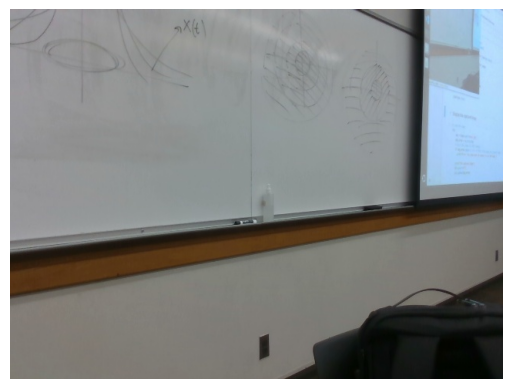

In [2]:
# Load the image
try:
    img = Image.open('photo.jpg')
    img_array = np.array(img)
    # Split the image into RGB channels
    if img_array.shape[-1] != 3: # Check if the image has 3 channels (RGB)
      print("Error: The image does not appear to be an RGB image.")

    print("The captured image")
    plt.axis("off")
    plt.imshow(img_array)


except FileNotFoundError:
    print("Error: The file photo.jpg was not found. Please make sure to capture an image first.")
except Exception as e:
    print(f"An error occurred: {e}")

### Convert the image into grayscale

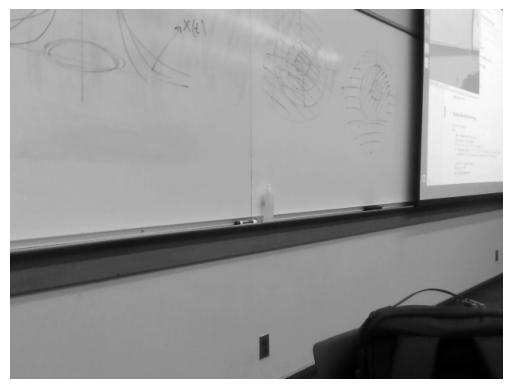

In [3]:
# Convert the image into gray-scale format
img = Image.open('photo.jpg')
# Convert the image to grayscale
img_gray = img.convert('L')

# Convert the grayscale image back to a NumPy array for display
img_gray_array = np.array(img_gray)


plt.axis("off")
plt.imshow(img_gray_array, cmap="gray")
plt.show()

### Define the image convolution

In [4]:
# Image convolution
def image_correlation(image_array, kernel):
    # Assume a gray-scale image
    assert len(image_array.shape) == 2, "Assume a grayscale image so far"
    H, W = image_array.shape
    kh, kw = kernel.shape
    
    # Correlation
    image_array_processed= np.zeros((H - kh + 1, W - kw + 1))
    for i in range(H - kh + 1):
        for j in range(W - kw + 1):
            image_array_processed[i, j] = np.sum(image_array[i:i+kh, j:j+kw] * kernel)
    return image_array_processed
def image_convolution(image_array, kernel):
    kernel_flipped = np.flip(kernel)
    return image_correlation(image_array, kernel_flipped)

### Apply Gaussian blurring

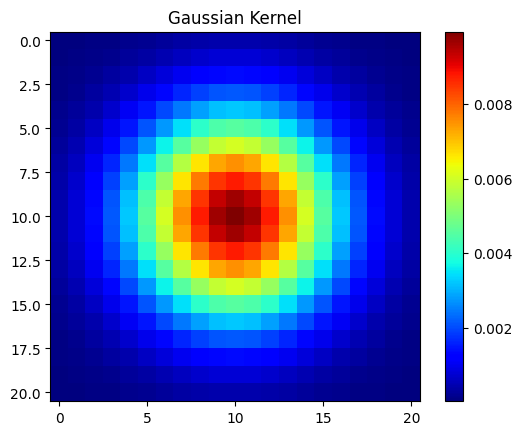

In [5]:
# Define the gaussian kernel
def create_gaussian_kernel(size, sigma=1):
    ax = np.linspace(-(size // 2), size // 2, size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    return kernel / (2 * np.pi * sigma**2)

kernel_size = 21
sigma = 4
gaussian_kernel = create_gaussian_kernel(kernel_size, sigma)
def visualize_gaussian_kernel(kernel):
    plt.close()
    plt.imshow(kernel, cmap='jet', interpolation='nearest')
    plt.colorbar()
    plt.title('Gaussian Kernel')
    plt.show()
visualize_gaussian_kernel(gaussian_kernel)

## Section 2: Laplacian as a "Zero-crossing" Edge Detector (1D)
Different from the lecture slides, we are going to calculate the Laplacian of 2D Gaussian distribution directly at first, and then demonstrate the estimation formulas shown in the slides


### Motivation
boundaries/edges $ \Rightarrow$ large gradient values $\Rightarrow$ local extrema of gradients $\Rightarrow$ zero point of second-derivative

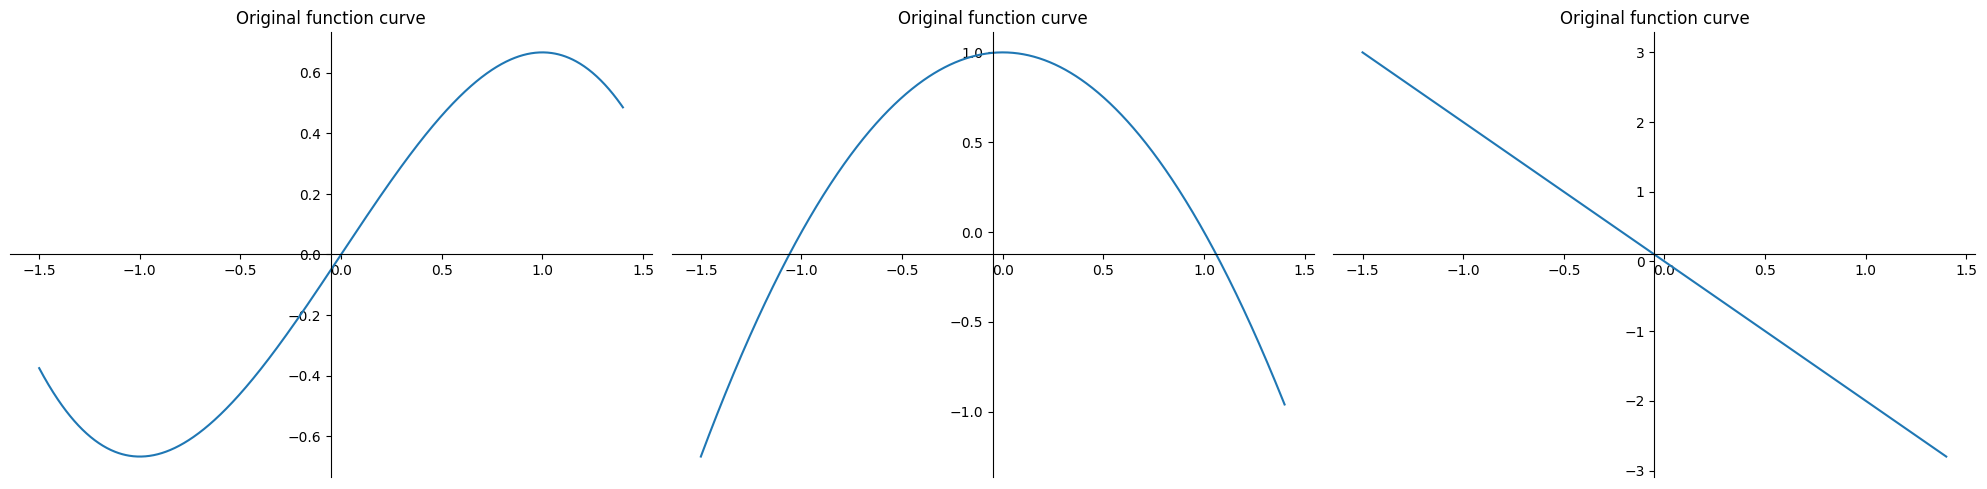

In [11]:
# Example showing the motivation behind Laplacian
t = np.linspace(-1.5, 1.4, 1000)
f = (-1/3)*t**3+t
df = -t**2+1
ddf = -2*t

# Create a figure
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Display the demos
axes[0].plot(t, f)
axes[0].set_title("Original function curve")
# Move left y-axis and bottom x-axis to centre, passing through (0,0)
axes[0].spines['left'].set_position('center')
axes[0].spines['bottom'].set_position('center')

# Eliminate upper and right axes
axes[0].spines['right'].set_color('none')
axes[0].spines['top'].set_color('none')

# Show ticks in the left and lower axes only
axes[0].xaxis.set_ticks_position('bottom')
axes[0].yaxis.set_ticks_position('left')

axes[1].plot(t, df)
axes[1].set_title("First Derivative")
# Move left y-axis and bottom x-axis to centre, passing through (0,0)
axes[1].spines['left'].set_position('center')
axes[1].spines['bottom'].set_position('center')

# Eliminate upper and right axes
axes[1].spines['right'].set_color('none')
axes[1].spines['top'].set_color('none')

# Show ticks in the left and lower axes only
axes[1].xaxis.set_ticks_position('bottom')
axes[1].yaxis.set_ticks_position('left')

axes[2].plot(t, ddf)
axes[2].set_title("Second Derivative")
# Move left y-axis and bottom x-axis to centre, passing through (0,0)
axes[2].spines['left'].set_position('center')
axes[2].spines['bottom'].set_position('center')

# Eliminate upper and right axes
axes[2].spines['right'].set_color('none')
axes[2].spines['top'].set_color('none')

# Show ticks in the left and lower axes only
axes[2].xaxis.set_ticks_position('bottom')
axes[2].yaxis.set_ticks_position('left')

plt.tight_layout()
plt.show()
plt.close()

### Mathematical Background

In 1D case, we have:
$$
G(x) = \frac{1}{\sqrt{2\pi}\sigma}\exp (-\frac{x^2}{2\sigma^2}), \frac{d^2G}{dx^2} = \frac{1}{\sigma^4} (x^2-1)\frac{1}{\sqrt{2\pi}\sigma}\exp (-\frac{x^2}{2\sigma^2})
$$

In [20]:
def step_function(step_width, step_height, t):
    result = np.zeros(t.shape[0]) + step_height
    result[t<-step_width/2] = 0
    result[t>step_width/2] = 0
    return result
def laplacian_1d(t, sigma):
    result = (-1/(sigma**4)) * (1 - t*t/(2*sigma**2))*(1/(np.sqrt(2*np.pi)*sigma))* np.exp(-t*t/(2*sigma*sigma))
    return result
def convolution_1d(signal, kernel):
    N = len(signal)
    M = len(kernel)
    
    # The length of the output for 'valid' mode
    target_len = N - M + 1
    
    # Reverse the kernel
    kernel_flip = np.flip(kernel)
    
    # Initialize result array with zeros
    result = np.zeros(target_len, dtype=np.double)
    
    # Perform sliding dot product
    for i in range(target_len):
        result[i] = np.dot(signal[i : i + M], kernel_flip)
        
    return result

## Section 3: Laplacian of Gaussian as a "Zero-crossing" Edge Detector (2D)

### Mathematical Background
Suppose we have an isotropic gaussian distribution given as $G\sim \mathcal{N}(0;\sigma)$, i.e. the probability distribution function is given by: 
$$
G(x,y) = \frac{1}{2\pi\sigma^2} \exp (-\frac{x^2+y^2}{2\sigma^2})
$$
Then, we have:
$$
\begin{aligned}
\nabla_x G&= \frac{1}{2\pi\sigma^2}\cdot (-\frac{x}{\sigma^2}) \exp (-\frac{x^2+y^2}{2\sigma^2})\\
\nabla_y G&= \frac{1}{2\pi\sigma^2}\cdot (-\frac{y}{\sigma^2}) \exp (-\frac{x^2+y^2}{2\sigma^2})\\
\nabla_x^2 G &= \frac{1}{2\pi\sigma^2}\cdot (-\frac{1}{\sigma^2} + \frac{x^2}{\sigma^4}) \exp (-\frac{x^2+y^2}{2\sigma^2})\\
\nabla_y^2 G &= \frac{1}{2\pi\sigma^2}\cdot (-\frac{1}{\sigma^2} + \frac{y^2}{\sigma^4}) \exp (-\frac{x^2+y^2}{2\sigma^2})\\
\end{aligned}
$$
Thus, we have
$$
\Delta G = \nabla_x^2 G + \nabla_y G^2 = \frac{1}{2\pi\sigma^2}\cdot (-\frac{2}{\sigma^2} + \frac{x^2 + y^2}{\sigma^4}) \exp (-\frac{x^2+y^2}{2\sigma^2}) = -\frac{1}{\pi\sigma^4} (1 - \frac{x^2+y^2}{2\sigma^2})\exp (-\frac{x^2+y^2}{2\sigma^2})
$$

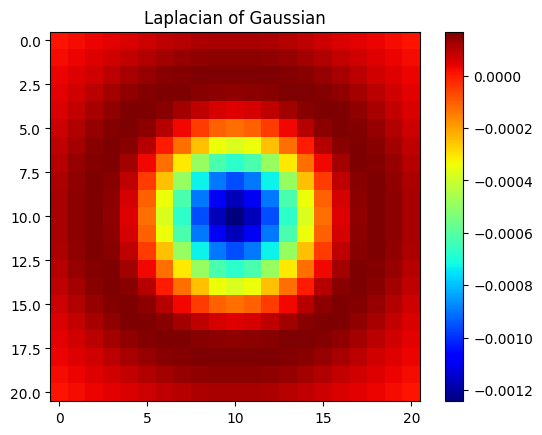

In [15]:
# Create Laplacian of Gaussian
def create_laplacian_of_gaussian_kernel(size, sigma=1):
    ax = np.linspace(-(size // 2), size // 2, size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = (-1/(np.pi*sigma**4)) * (1 - (xx**2 + yy**2)/(2*sigma*sigma)) * np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    return kernel

laplacian = create_laplacian_of_gaussian_kernel(21, 4)
plt.close()
plt.imshow(laplacian, cmap='jet')
plt.colorbar()
plt.title('Laplacian of Gaussian')
plt.show()

### Alternatively, we can build up the laplacian of gaussian approximately from convolution

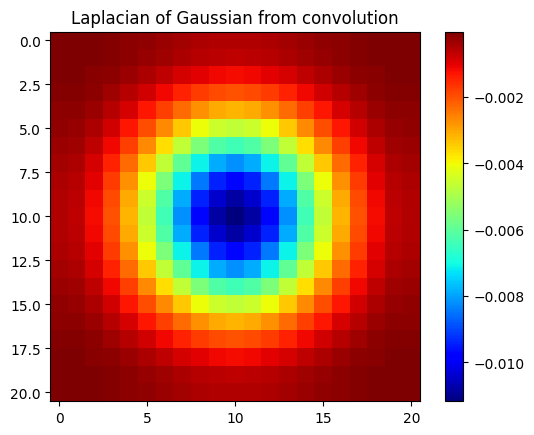

In [16]:
# Image sharpening kernel
kernel_sharp = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])
gaussian_kernel_padding = np.pad(gaussian_kernel, pad_width = 1, mode="constant", constant_values=0)
laplacian_convolution = image_convolution(gaussian_kernel_padding, -kernel_sharp)
plt.close()
plt.imshow(laplacian_convolution, cmap='jet')
plt.colorbar()
plt.title('Laplacian of Gaussian from convolution')
plt.show()

### Effect of Laplacian kernel

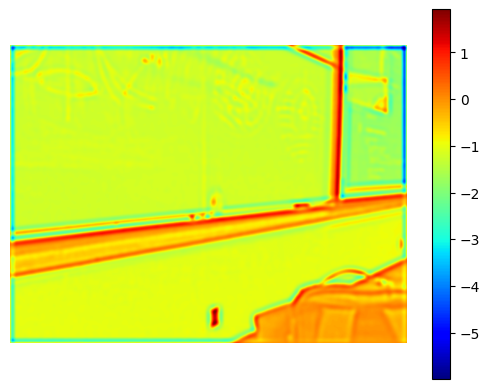

In [17]:
# Padding the image to ensure a constant size
img_gray_array_padding = np.pad(img_gray_array, pad_width=(int)((laplacian.shape[0]-1)/2), mode='constant', constant_values=0)
img_gray_laplacian = image_convolution(img_gray_array_padding, laplacian)
plt.axis("off")
plt.imshow(img_gray_laplacian, cmap="jet")
plt.colorbar()
plt.show()

### In practice, people also use the following kernel as the approximate laplacian of gaussian to save calculation cost

In [18]:
# image sharpening
print(create_laplacian_of_gaussian_kernel(3, 0.5))

[[ 0.27984235  0.68925694  0.27984235]
 [ 0.68925694 -5.09295818  0.68925694]
 [ 0.27984235  0.68925694  0.27984235]]


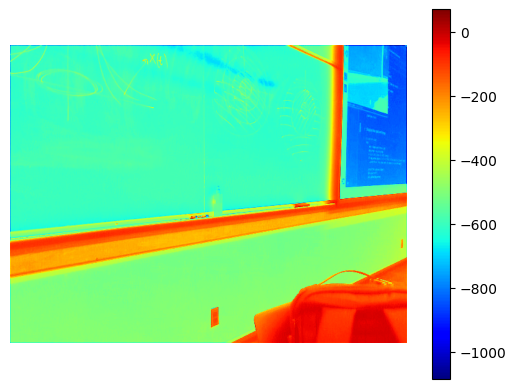

In [19]:
# Laplacian of Gaussian
laplacian_kernel = np.array([
    [0, 1, 0],
    [1, -8, 1],
    [0, 1, 0]
])
img_gray_array_padding = np.pad(img_gray_array, pad_width=1, mode='constant', constant_values=0)
img_gray_laplacian = image_convolution(img_gray_array_padding, laplacian_kernel)
plt.axis("off")
plt.imshow(img_gray_laplacian, cmap="jet")
plt.colorbar()
plt.show()

## Section 4: Laplacian of Gaussian as a Scale/Blob Detector (1D)
We want to detect a "blob". 

### Signals("Blobs") at different scales

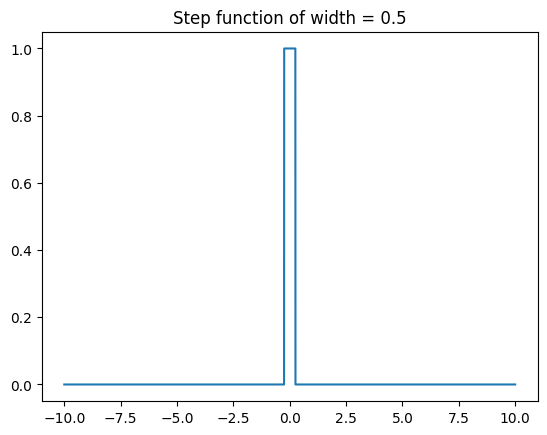

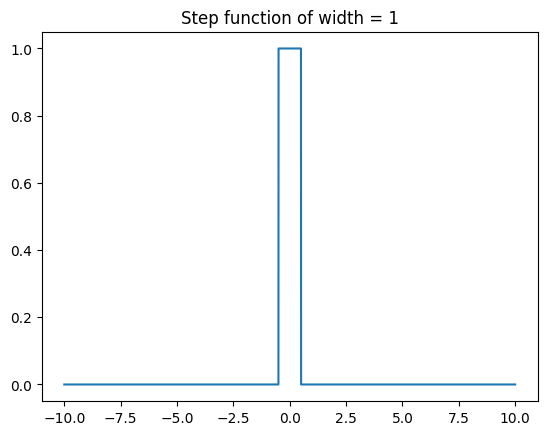

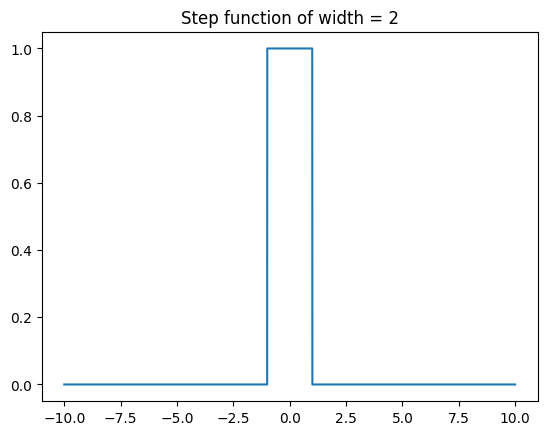

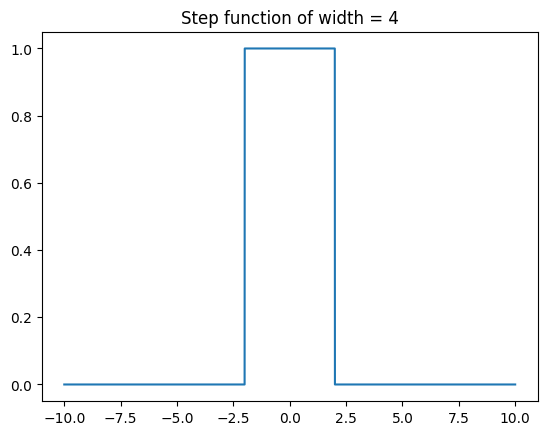

In [36]:
# Visualize the step functions of two different widths
t = np.linspace(-10, 10, 10000)
s1_width = 0.5
s2_width = 1
s3_width = 2
s4_width = 4
step1 = step_function(s1_width, 1, t)
step2 = step_function(s2_width, 1, t)
step3 = step_function(s3_width, 1, t)
step4 = step_function(s4_width, 1, t)
plt.plot(t, step1)
plt.title("Step function of width = " + str(s1_width))
plt.show()
plt.plot(t, step2)
plt.title("Step function of width = " + str(s2_width))
plt.show()
plt.plot(t, step3)
plt.title("Step function of width = " + str(s3_width))
plt.show()
plt.plot(t, step4)
plt.title("Step function of width = " + str(s4_width))
plt.show()

### Laplacian of Gaussian on 1D

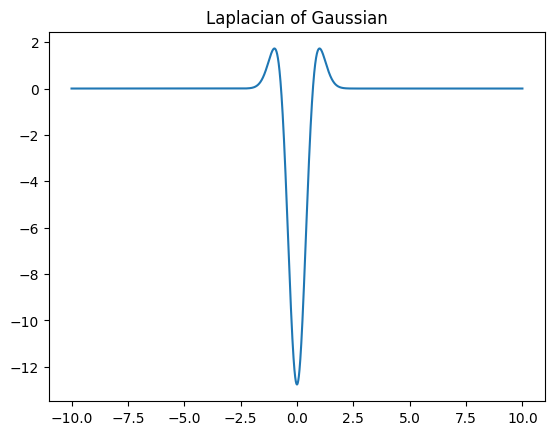

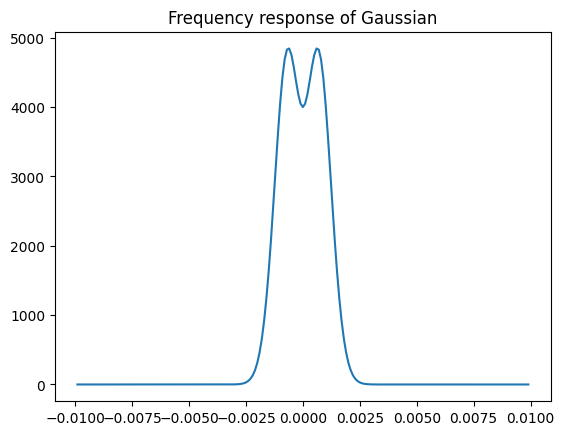

In [37]:
# Create the Laplacian of Gaussian
gaussian_laplacian = laplacian_1d(t, sigma=0.5)
plt.plot(t, gaussian_laplacian)
plt.title("Laplacian of Gaussian")
plt.show()

gaussian_laplacian_ft = np.abs(np.fft.fft(gaussian_laplacian))
freq = np.fft.fftfreq(t.shape[0])

mask = (freq > -0.01).astype(bool) & (freq < 0.01).astype(bool)

# Extract one window to display
freq_display = freq[mask]
gaussian_laplacian_ft_display = gaussian_laplacian_ft[mask]


sort_idx = np.argsort(freq_display)
freq_display = freq_display[sort_idx]
gaussian_laplacian_ft_display = gaussian_laplacian_ft_display[sort_idx]
plt.plot(freq_display, gaussian_laplacian_ft_display)
plt.title("Frequency response of Gaussian")
plt.show()

### Frequency response of step functions & Laplacian as a Band-pass Filter

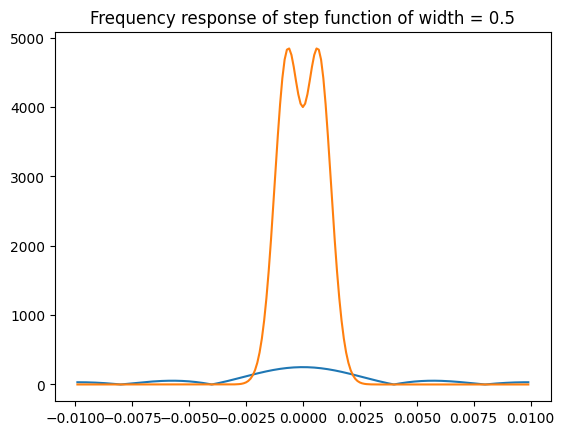

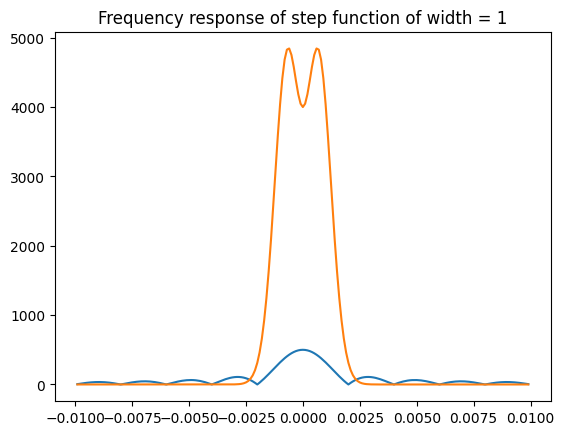

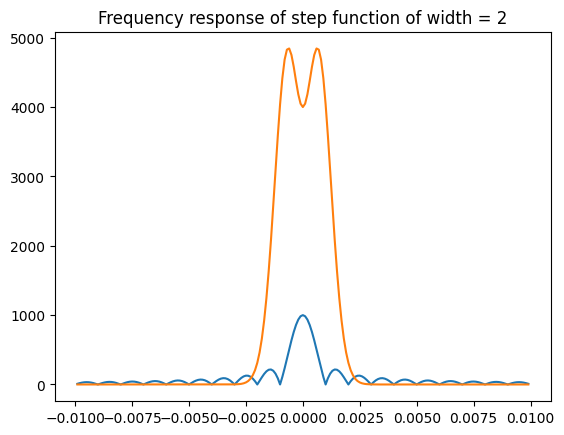

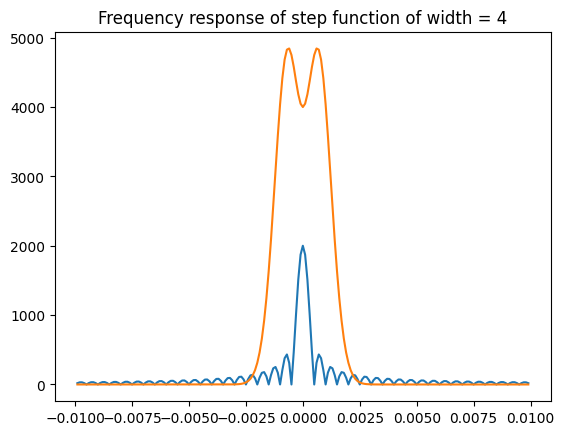

In [38]:
step1_ft = np.abs(np.fft.fft(step1))
step2_ft = np.abs(np.fft.fft(step2))
step3_ft = np.abs(np.fft.fft(step3))
step4_ft = np.abs(np.fft.fft(step4))

# Extract one window to display
step1_ft_display = step1_ft[mask]
step2_ft_display = step2_ft[mask]
step3_ft_display = step3_ft[mask]
step4_ft_display = step4_ft[mask]


step1_ft_display = step1_ft_display[sort_idx]
step2_ft_display = step2_ft_display[sort_idx]
step3_ft_display = step3_ft_display[sort_idx]
step4_ft_display = step4_ft_display[sort_idx]
plt.plot(freq_display, step1_ft_display, freq_display, gaussian_laplacian_ft_display)
plt.title("Frequency response of step function of width = " + str(s1_width))
plt.show()
plt.plot(freq_display, step2_ft_display, freq_display, gaussian_laplacian_ft_display)
plt.title("Frequency response of step function of width = " + str(s2_width))
plt.show()
plt.plot(freq_display, step3_ft_display, freq_display, gaussian_laplacian_ft_display)
plt.title("Frequency response of step function of width = " + str(s3_width))
plt.show()
plt.plot(freq_display, step4_ft_display, freq_display, gaussian_laplacian_ft_display)
plt.title("Frequency response of step function of width = " + str(s4_width))
plt.show()

### Check the convolution results

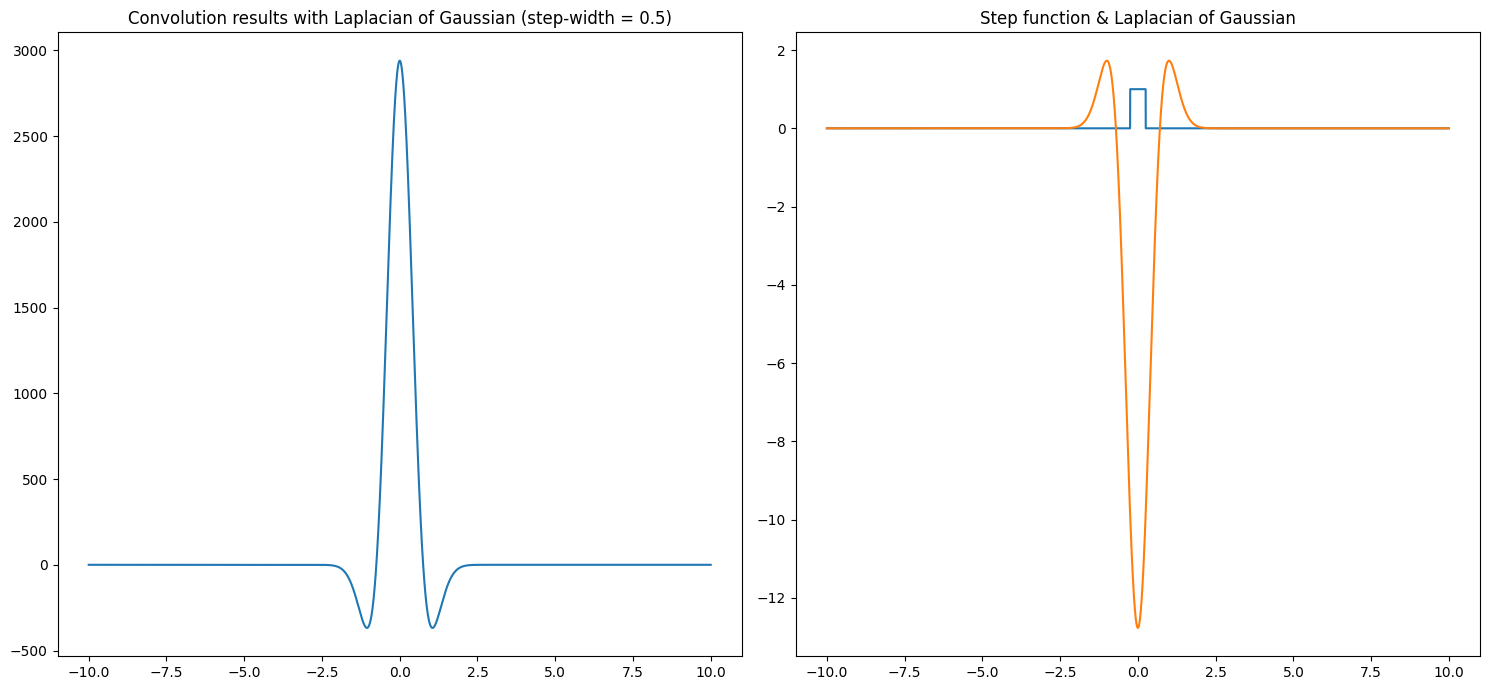

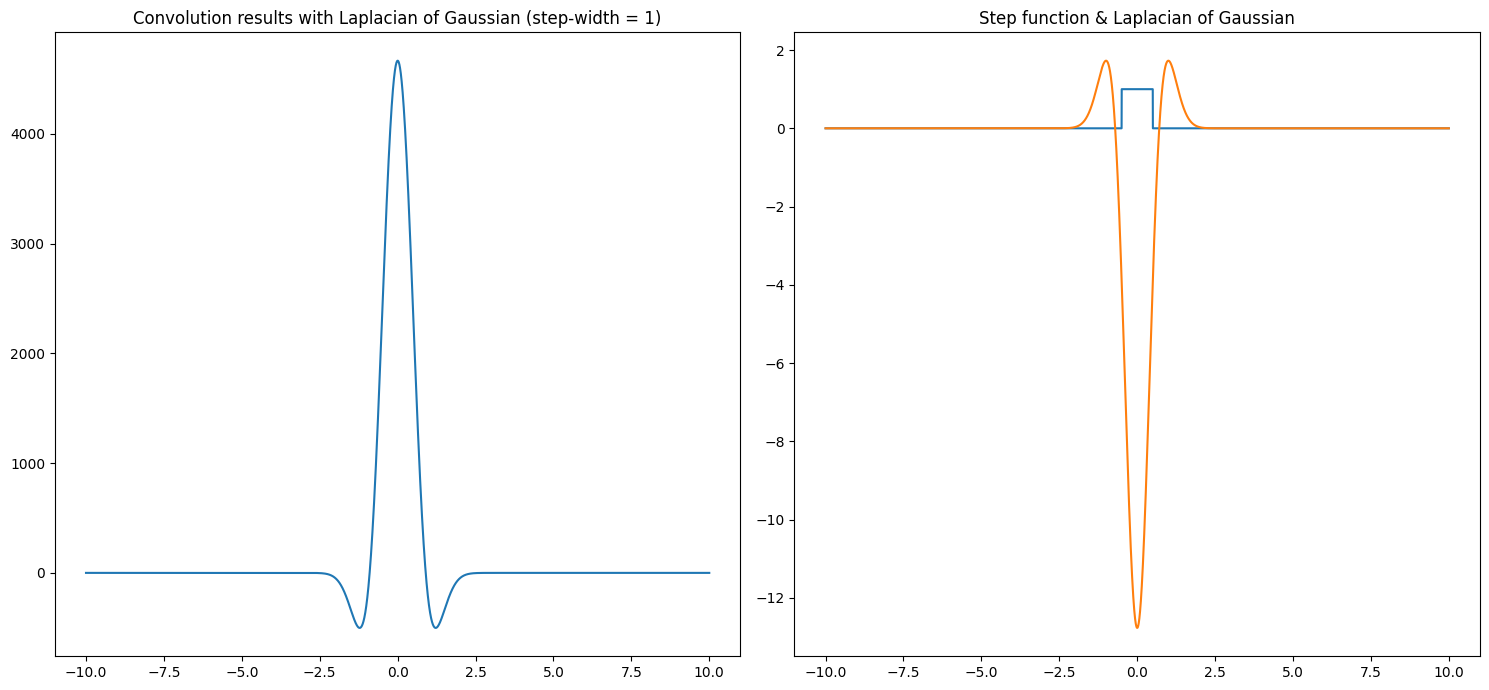

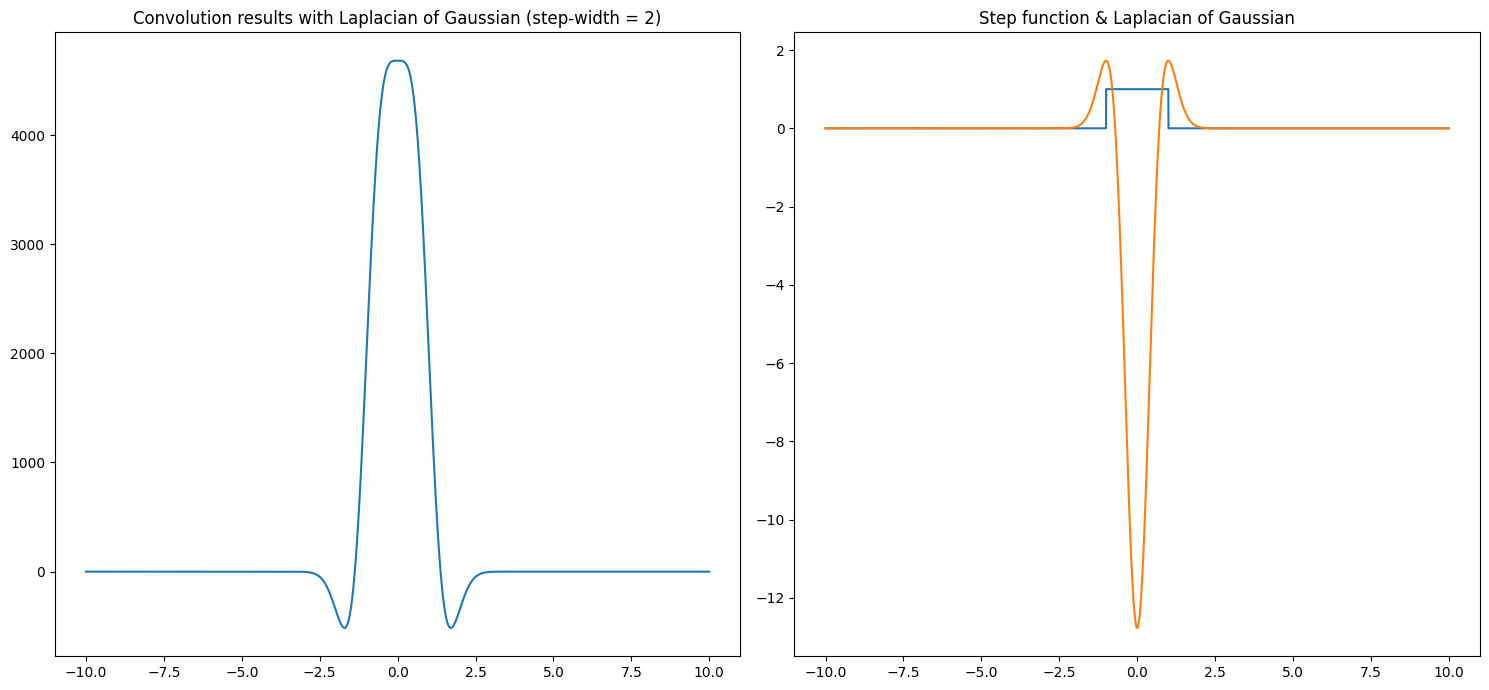

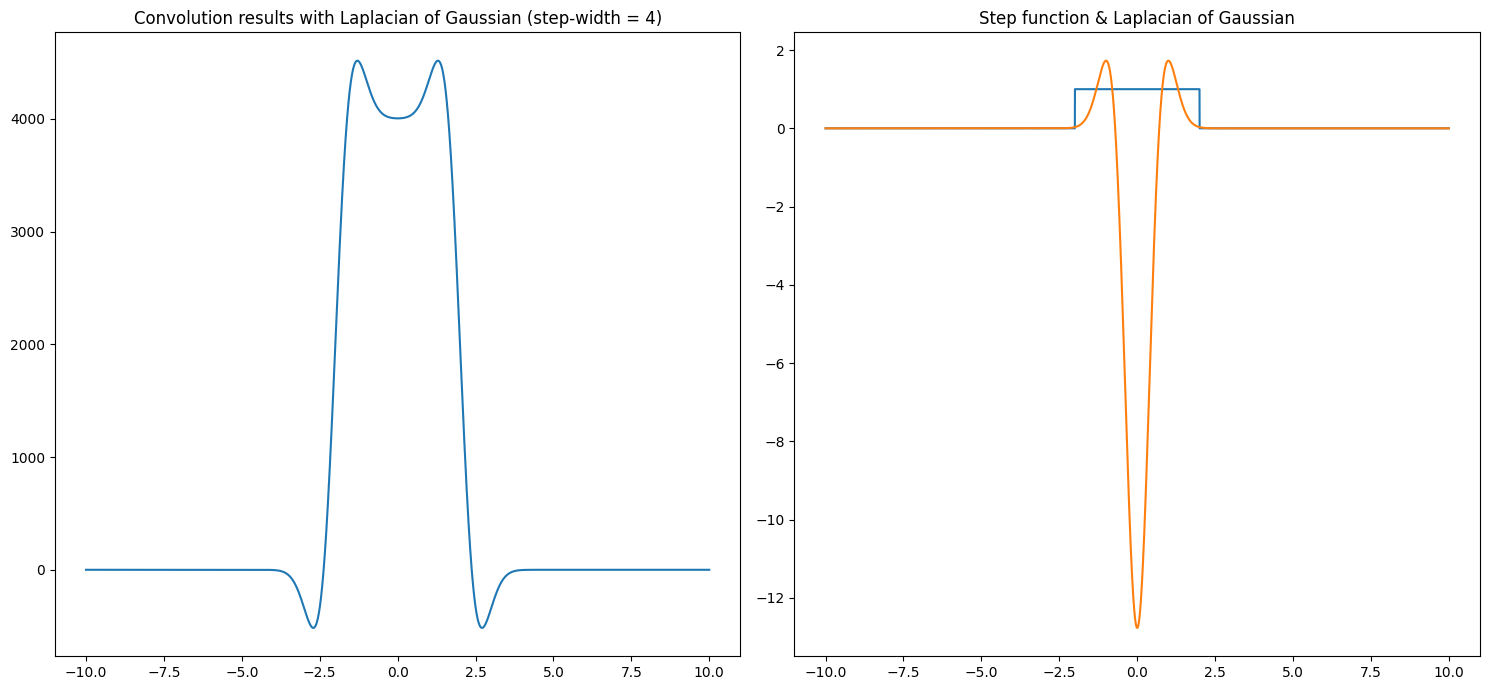

In [40]:
step1_padding = np.pad(step1, pad_width=(int(len(gaussian_laplacian)/2), int(len(gaussian_laplacian)/2) - 1), mode='constant', constant_values=0)
step1_conv = convolution_1d(step1_padding, -gaussian_laplacian)
step2_padding = np.pad(step2, pad_width=(int(len(gaussian_laplacian)/2), int(len(gaussian_laplacian)/2) - 1), mode='constant', constant_values=0)
step2_conv = convolution_1d(step2_padding, -gaussian_laplacian)
step3_padding = np.pad(step3, pad_width=(int(len(gaussian_laplacian)/2), int(len(gaussian_laplacian)/2) - 1), mode='constant', constant_values=0)
step3_conv = convolution_1d(step3_padding, -gaussian_laplacian)
step4_padding = np.pad(step4, pad_width=(int(len(gaussian_laplacian)/2), int(len(gaussian_laplacian)/2) - 1), mode='constant', constant_values=0)
step4_conv = convolution_1d(step4_padding, -gaussian_laplacian)

# Create a figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))


# Display the convolution result
axes[0].plot(t, step1_conv)
axes[0].set_title("Convolution results with Laplacian of Gaussian (step-width = " + str(s1_width) + ")")

# Display the comparison
axes[1].plot(t, step1, t, gaussian_laplacian)
axes[1].set_title("Step function & Laplacian of Gaussian")


plt.tight_layout()
plt.show()

# Following figures
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))


axes[0].plot(t, step2_conv)
axes[0].set_title("Convolution results with Laplacian of Gaussian (step-width = " + str(s2_width) + ")")

axes[1].plot(t, step2, t, gaussian_laplacian)
axes[1].set_title("Step function & Laplacian of Gaussian")


plt.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))


axes[0].plot(t, step3_conv)
axes[0].set_title("Convolution results with Laplacian of Gaussian (step-width = " + str(s3_width) + ")")


axes[1].plot(t, step3, t, gaussian_laplacian)
axes[1].set_title("Step function & Laplacian of Gaussian")


plt.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))


axes[0].plot(t, step4_conv)
axes[0].set_title("Convolution results with Laplacian of Gaussian (step-width = " + str(s4_width) + ")")


axes[1].plot(t, step4, t, gaussian_laplacian)
axes[1].set_title("Step function & Laplacian of Gaussian")


plt.tight_layout()
plt.show()


### Also, we can check the effect of standard deviation on Laplacian of Gaussian

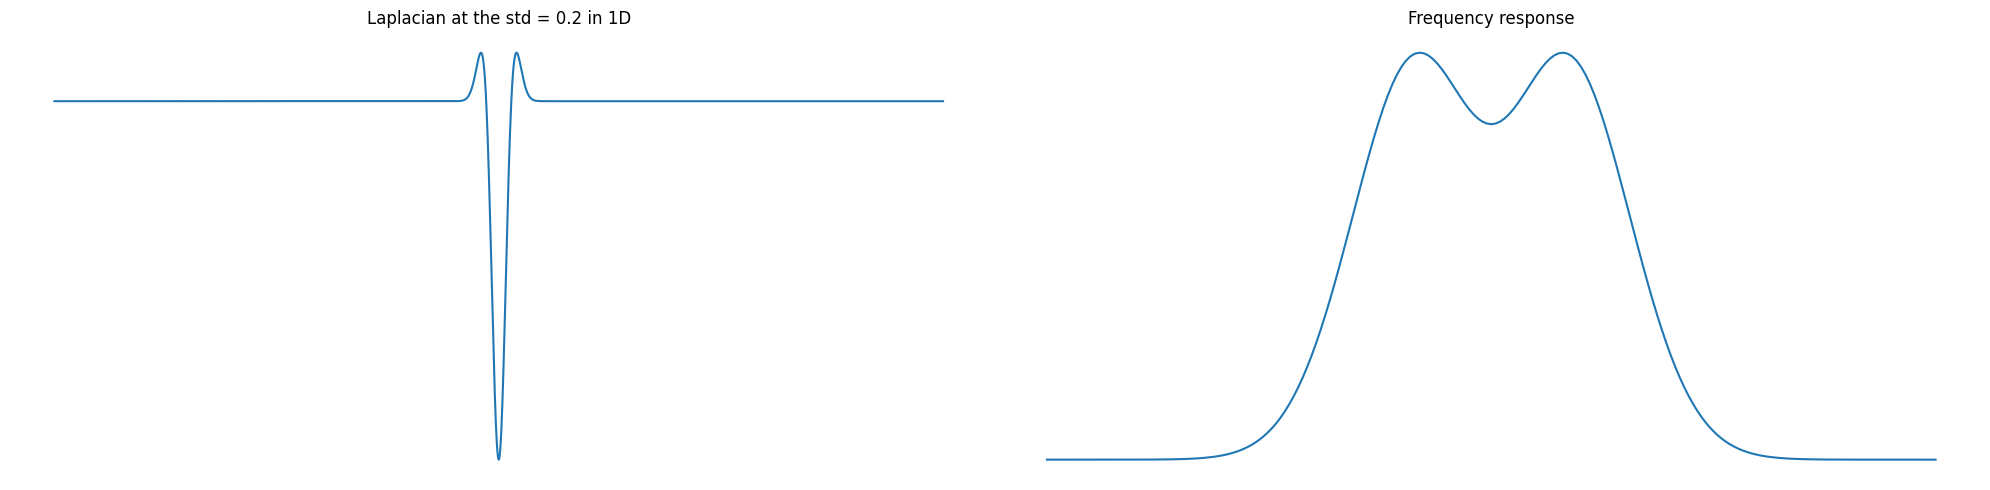

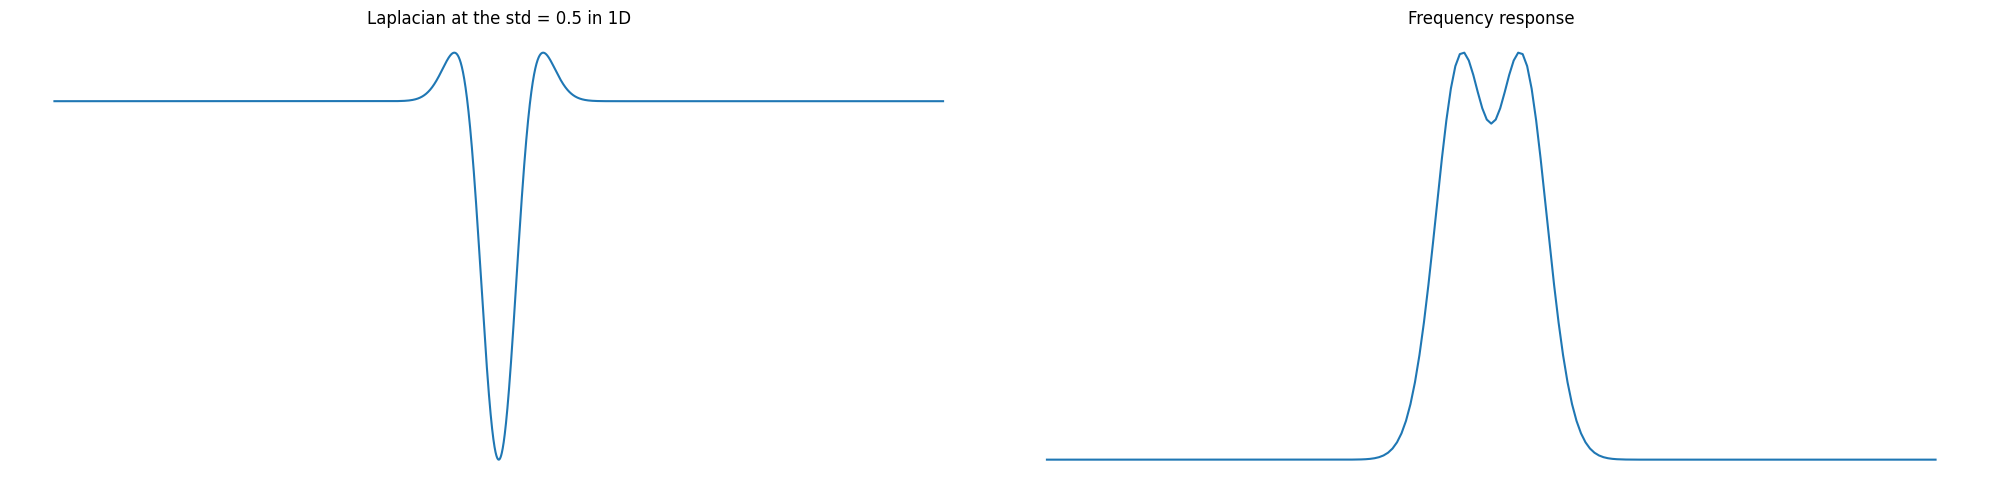

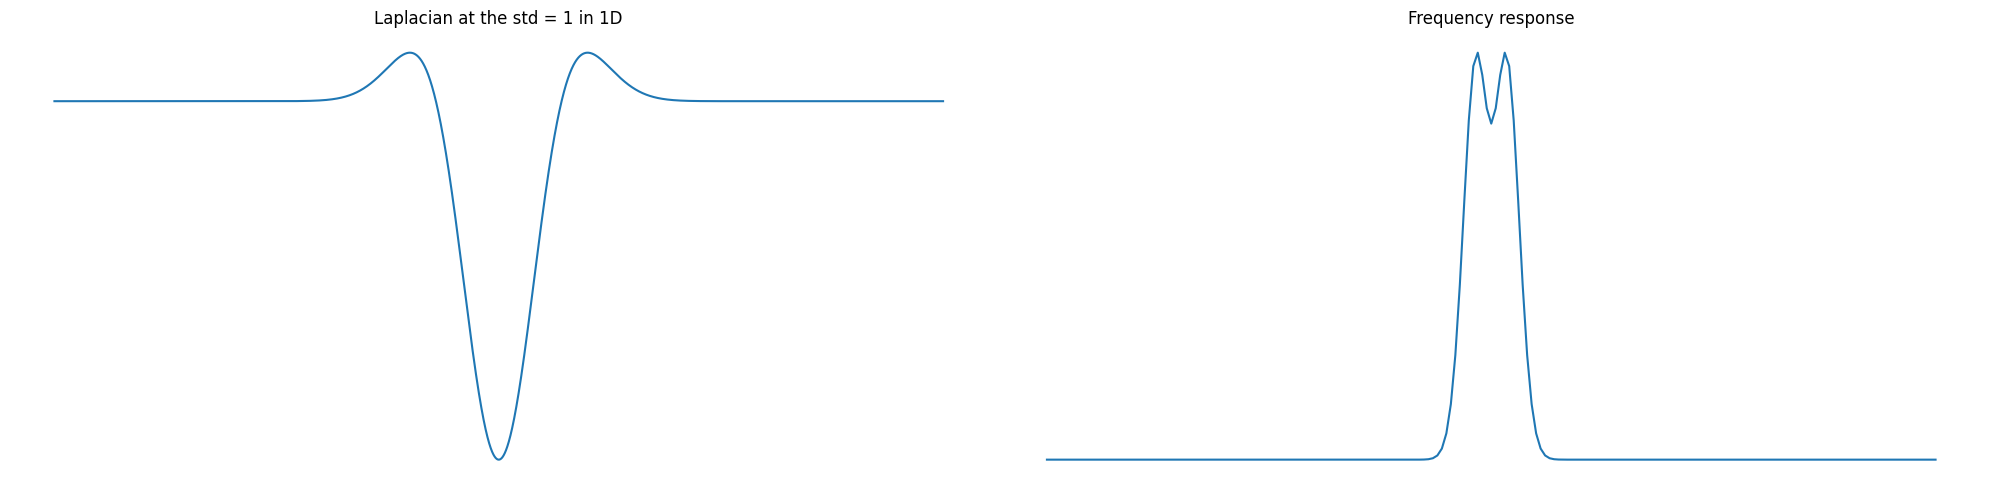

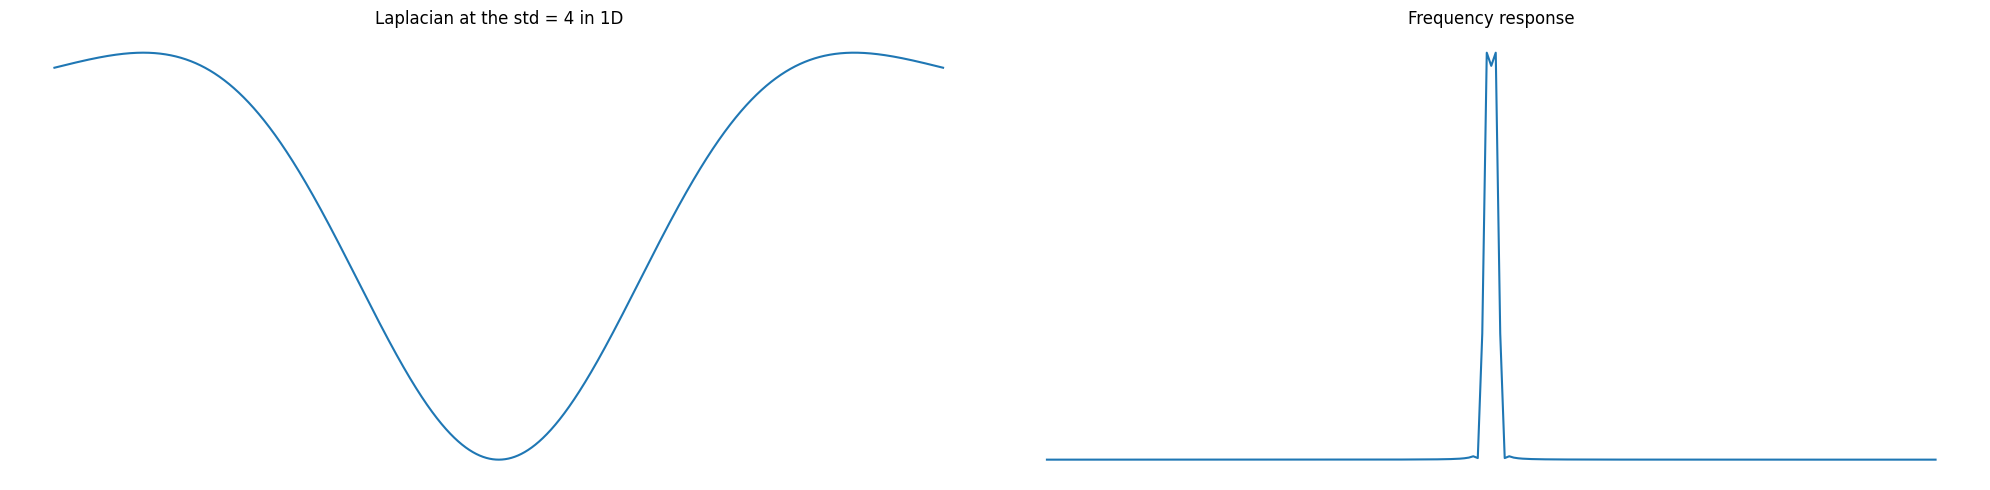

In [163]:
# Create a figure
for i in [0.2, 0.5, 1, 4]:
    gaussian_laplacian = laplacian_1d(t, sigma=i)

    gaussian_laplacian_ft = np.abs(np.fft.fft(gaussian_laplacian))

    gaussian_laplacian_ft_display = gaussian_laplacian_ft[mask]

    gaussian_laplacian_ft_display = gaussian_laplacian_ft_display[sort_idx]
    
    # Display the frequency response
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    # Display the signal in time domain
    axes[0].plot(t, gaussian_laplacian)
    axes[0].set_title('Laplacian at the std = ' + str(i) + " in 1D")
    axes[0].axis('off')
    
    # Display the frequency response
    axes[1].plot(freq_display, gaussian_laplacian_ft_display)
    axes[1].set_title('Frequency response')
    axes[1].axis('off')
    
    
    plt.tight_layout()
    plt.show()

### Summary
1. The Laplacian of Gaussian can help in detecting zero-crossing edges
2. We can use the Laplacian of Gaussian to evaluate the scale of the signal
   1. If the scale is too small, the absolute value of the extrema won't be very large
   2. If the scale is too big, no maxima is observed at the center

## Section 5: Laplacian of Gaussian as a Scale/Blob Detector (2D)

### Examples of Blobs

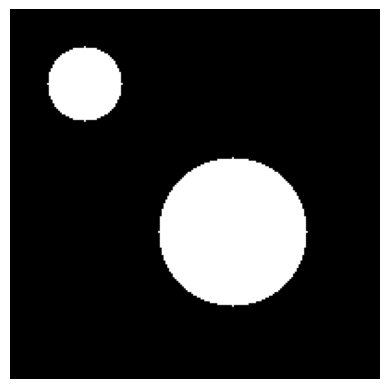

In [61]:
# Create a picture of a circle
def create_circle(grid, center, r):
    assert len(grid.shape) == 2, "Only support a plane"
    result = np.copy(grid)
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            if (i-center[0])**2 + (j-center[1])**2 <= r * r:
                result[i,j] = 1
    return result

grid = np.zeros((200, 200))
circle = create_circle(grid, [40, 40], 20)
circle_array = create_circle(circle, [120, 120], 40)
plt.imshow(circle_array, cmap="gray")
plt.axis("off")
plt.show()


### LoG-based Blob Detector / Scale-invaraint Feature Descriptor

From the demonstrations in 1D, we can transfer the following ideas to 2D to detect the blob
1. Apply the convolution with Laplacian of Gaussian on the target image
2. Obtain the scale response 
3. Determine the global extrema values & their locations
    1. If the global extrema locations distribute as a ring $\Rightarrow$ the scale/std of the blob detector might be too small
    2. If the global extrema locations concentrate on specific points $\Rightarrow$ the points are potential centers of blobs
    3. The value of the global extrema reaches the maximum at certain scale/std $\sigma$ $\Rightarrow$ the potential radius of the blob is given by $\sqrt{2}\sigma$

Location with the largest scale response: [51, 30]
Value of the largest scale response: 0.32527218214691134


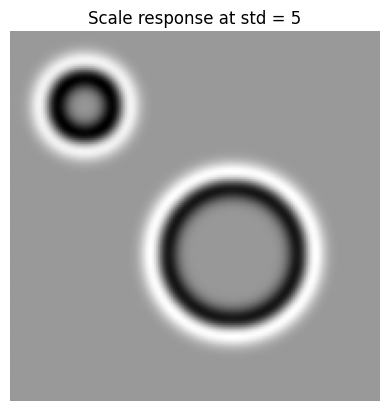

Location with the largest scale response: [40, 40]
Value of the largest scale response: 0.5411862762625574


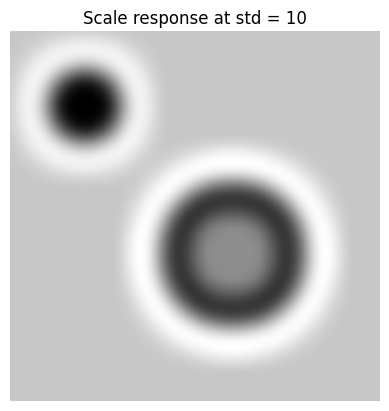

Location with the largest scale response: [40, 40]
Value of the largest scale response: 0.7308339407104484


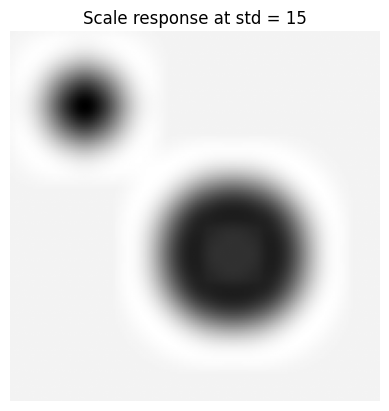

Location with the largest scale response: [106, 120]
Value of the largest scale response: 0.7250024584879977


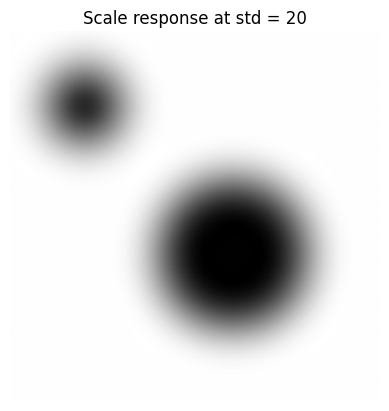

Location with the largest scale response: [113, 120]
Value of the largest scale response: 0.6698903013316437


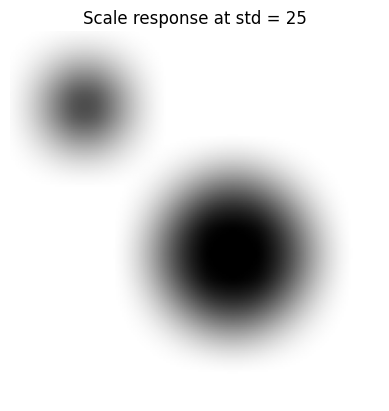

Location with the largest scale response: [114, 120]
Value of the largest scale response: 0.6121173278881649


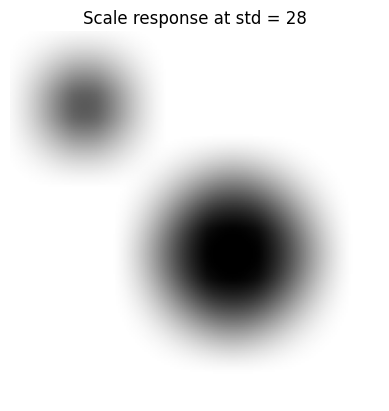

Location with the largest scale response: [114, 120]
Value of the largest scale response: 0.3953935272990062


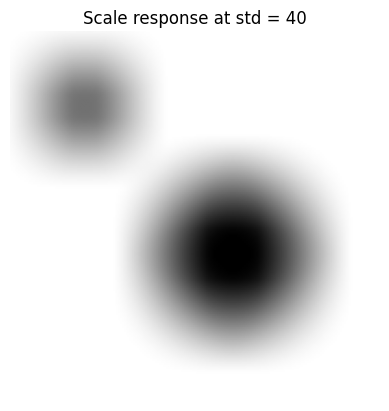

In [64]:
# Evaluation on different hyperparameters
for i in [5, 10, 15, 20, 25, 28, 40]:
    laplacian = i*i*create_laplacian_of_gaussian_kernel(101, i) # Normalization of the kernel
    circle_array_padding = np.pad(circle_array, pad_width=(int)((laplacian.shape[0]-1)/2), mode='constant', constant_values=0)
    circle_laplacian = image_convolution(circle_array_padding, laplacian)
    plt.imshow(circle_laplacian, cmap='gray')
    # Get the index of the maximum value in the flattened array
    flat_index = (np.abs(circle_laplacian)).argmax()
    
    # Convert the flattened index to 2D (row, column) indices
    row, col = np.unravel_index(flat_index, circle_laplacian.shape)
    response = np.max(np.abs(circle_laplacian))
    print("Location with the largest scale response: " + f"[{row}, {col}]")
    print("Value of the largest scale response: " + str(response))
    plt.axis("off")
    plt.title("Scale response at std = " + str(i))
    plt.show()

### Characteristic Scale
From examples in 1D, we know that when the radius of the blob is close to the band-width of the Laplacian of Gaussian, the scale response will be the largest.
Thus, from the mathematical formula given in Section 3, we have:
$$
x^2 + y^2 - 2\sigma^2 = 0 \Rightarrow \sigma = \sqrt{(x^2+y^2)/2} = r/\sqrt{2}
$$

For the given example, the characteristic scale should be approximately
$$
\sigma_1 = r_1/\sqrt{2} = 14.14, \sigma_2 = r_2/\sqrt{2} = 28.28
$$

### Similarly, the idea can be applied on real-time captured image

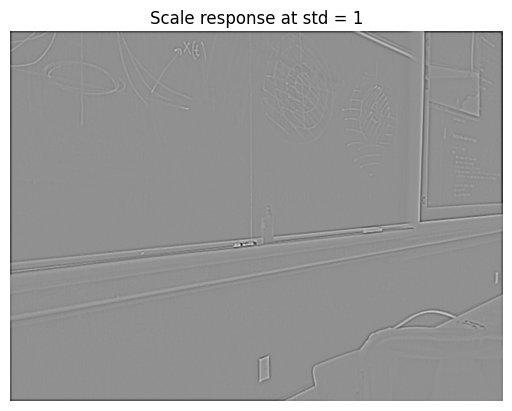

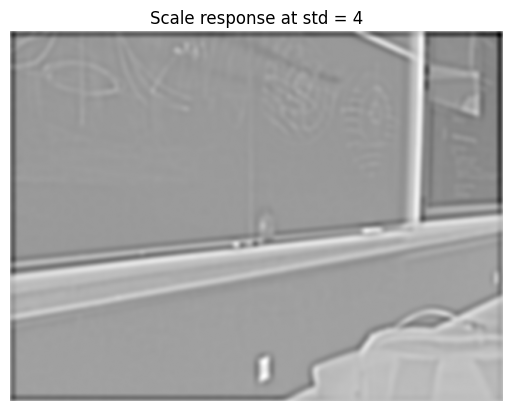

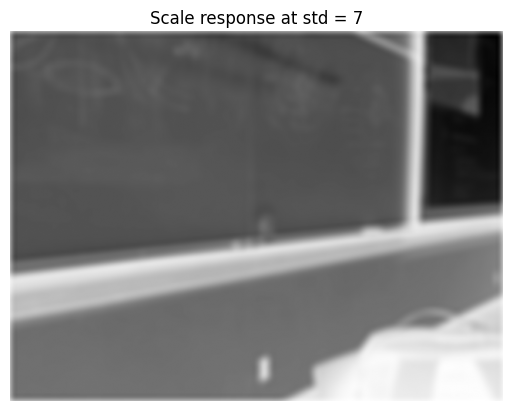

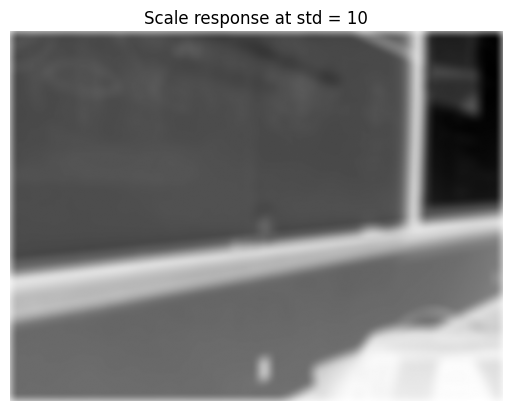

In [65]:
# Evaluation on different hyperparameters
for i in [1, 4, 7, 10]:
    laplacian = create_laplacian_of_gaussian_kernel(21, i)
    img_gray_array_padding = np.pad(img_gray_array, pad_width=(int)((laplacian.shape[0]-1)/2), mode='constant', constant_values=0)
    img_gray_laplacian = image_convolution(img_gray_array_padding, laplacian)
    plt.imshow(img_gray_laplacian, cmap='gray')
    plt.axis("off")
    plt.title("Scale response at std = " + str(i))
    plt.show()
    